In [1]:
import pandas as pd
import numpy as np, warnings, itertools
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline
import statsmodels.api as sm
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.stattools import adfuller
from sklearn.metrics import mean_squared_error
from math import sqrt

warnings.simplefilter("ignore")
plt.style.use('gadfly.mplstyle')

https://docs.google.com/presentation/d/1G49ouOiGlvBv0TEASKTQvsY_mkj_25nqtFdEFgcb1Kg/edit#slide=id.g6ee69c289b_2_6

# Load and Transform Data

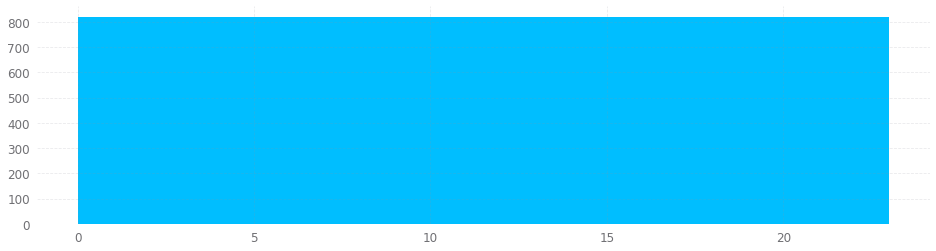

In [2]:
df = pd.read_csv('Metro_Interstate_Traffic_Volume.csv')

# get datetime and traffic volume
df_traffic = df[['date_time','traffic_volume']].copy()

# convert to datetime
df_traffic['date_time'] = pd.to_datetime(df_traffic['date_time'])

# set index
df_traffic.set_index('date_time', inplace=True)

# create a daterange for every hour
daterange = pd.DataFrame(pd.date_range('2016-07-01', '2018-09-28 23:00:00', freq='h'))

# set index to daterange
daterange.set_index(0, inplace=True)

# merge the dfs
df_traffic_hour = df_traffic['2016-07-01':].resample('H').mean()
df_hour = daterange.merge(df_traffic_hour, how='left', left_index=True, right_index=True)

# add forward and back filled columns
df_hour['plus1'] = df_hour['traffic_volume'].ffill(axis=0)
df_hour['minus1'] = df_hour['traffic_volume'].bfill(axis=0)

# average the f/b filled columns
avg_hours = (df_hour['plus1'] + df_hour['minus1']) / 2

# fill nas with the averaged values
df_hour['traffic_filled'] = df_hour['traffic_volume'].fillna(avg_hours)

df_hour['hour'] = df_hour.index.hour

# show even # of hours in each day
df_hour['hour'].hist(bins=24, figsize=(16,4));

# subset to include only the traffic counts
df_hour = df_hour['traffic_filled']

#converting to daily
daily = df_hour.resample('D').sum()

---

# Train/ Test Split

In [3]:
# specify the train/test split length

split = int(len(daily)*.9)
train = daily[:split]
test = daily[split:]

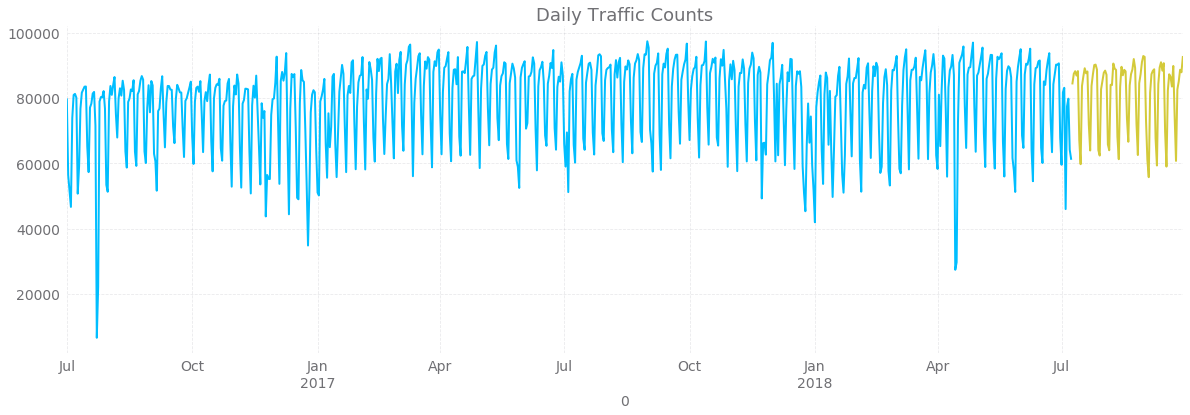

In [4]:
train.plot()
test.plot(figsize=(20, 6), 
            title= 'Daily Traffic Counts',
            fontsize=14);

<Figure size 1080x576 with 0 Axes>

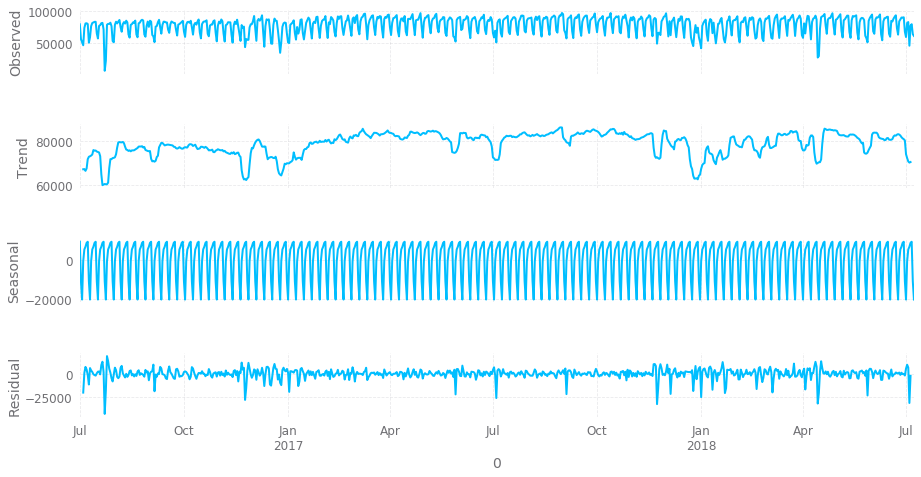

In [5]:
decomposition = seasonal_decompose(train)
fig = plt.figure(figsize=(15,8))
fig = decomposition.plot()
fig.set_size_inches(15, 8)

_____

# EDA

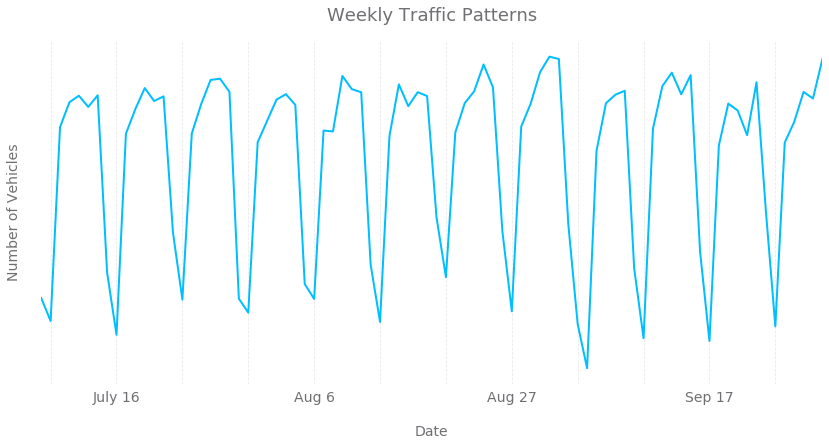

In [6]:
# plot daily traffic patterns
daily[-7*12:].plot(fontsize = 14,
                   figsize = (14,7),
                   use_index=False)
plt.ylabel('Number of Vehicles', labelpad=20)
plt.title('Weekly Traffic Patterns', pad=20)
plt.xlabel('Date',
           labelpad=20)
plt.xticks(ticks = range(1,81,7),
           labels=['', 'July 16', '',
                   '', 'Aug 6', '', '',
                   'Aug 27', '', '',
                   'Sep 17', '','Sep 24'],
          rotation=0,
          ha='center')
plt.yticks([]);

______

# Stationarity with Dickey-Fuller

In [7]:
#create a function that will help us to quickly 
def test_stationarity(timeseries, window):
    
    #Determing rolling statistics
    rolmean = timeseries.rolling(window=window).mean()
    rolstd = timeseries.rolling(window=window).std()

    #Plot rolling statistics:
    fig = plt.figure(figsize=(15, 4))
    orig = plt.plot(timeseries.iloc[window:], color='blue',label='Original')
    mean = plt.plot(rolmean, color='red', label='Rolling Mean')
    std = plt.plot(rolstd, color='black', label = 'Rolling Std')
    plt.legend(loc='best')
    plt.title('Rolling Mean & Standard Deviation')
    plt.show()
    
    #Perform Dickey-Fuller test:
    print ('Results of Dickey-Fuller Test:')
    dftest = adfuller(timeseries, autolag='AIC')
    dfoutput = pd.Series(dftest[0:4], index=['Test Statistic','p-value','#Lags Used','Number of Observations Used'])
    for key,value in dftest[4].items():
        dfoutput['Critical Value (%s)'%key] = value
    print (dfoutput)

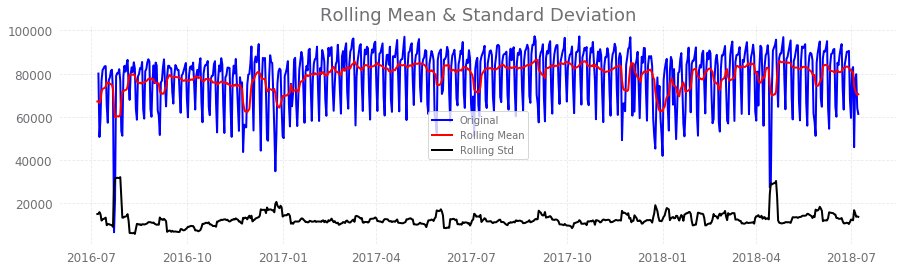

Results of Dickey-Fuller Test:
Test Statistic                  -2.877788
p-value                          0.047993
#Lags Used                      20.000000
Number of Observations Used    717.000000
Critical Value (1%)             -3.439503
Critical Value (5%)             -2.865579
Critical Value (10%)            -2.568921
dtype: float64


In [8]:
test_stationarity(train, 7)

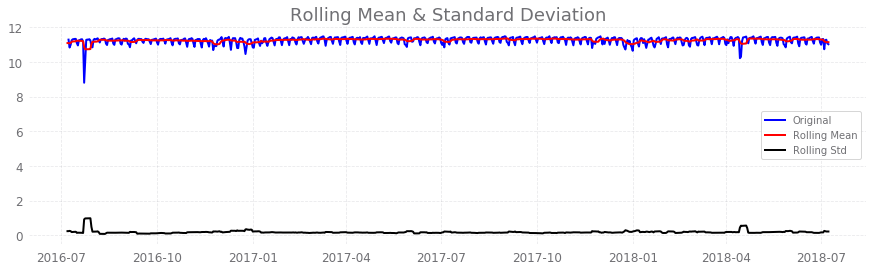

Results of Dickey-Fuller Test:
Test Statistic                  -3.231827
p-value                          0.018215
#Lags Used                      20.000000
Number of Observations Used    717.000000
Critical Value (1%)             -3.439503
Critical Value (5%)             -2.865579
Critical Value (10%)            -2.568921
dtype: float64


In [9]:
daily_log = np.log(train)
test_stationarity(daily_log, 7)

 -----

# ACF and PACF

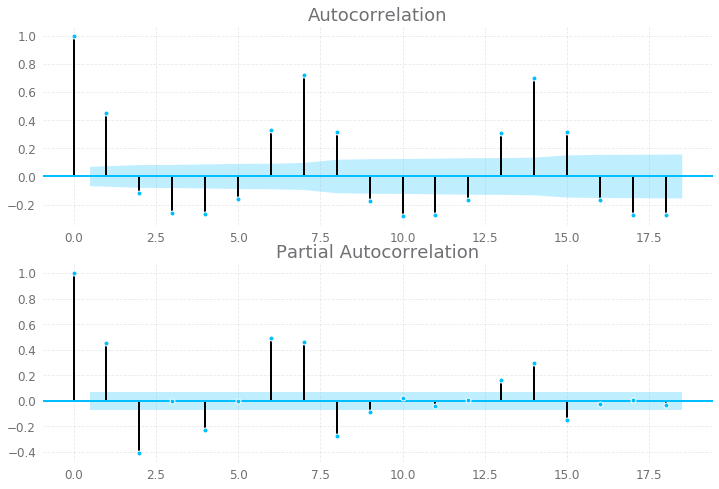

In [10]:
fig = plt.figure(figsize=(12,8))
ax1 = fig.add_subplot(211)
#plot the ACF
fig = sm.graphics.tsa.plot_acf(daily, lags=18, ax=ax1)
ax2 = fig.add_subplot(212)
#plot the PACF
fig = sm.graphics.tsa.plot_pacf(daily, lags=18, ax=ax2)

_____

# ARIMA Terms

In [11]:
# create the all of the combinations of the AR and MA terms
p = d = q = range(0, 3)
pdq = list(itertools.product(p, d, q))
seasonal_pdq = [(x[0], x[1], x[2], 7) for x in list(itertools.product(p, d, q))]

In [12]:
# grid search through all of the combinations to find best MSE
run_res = []

for param in pdq:
    for param_seasonal in seasonal_pdq:
        try:
            mod = sm.tsa.statespace.SARIMAX(train,
                                            order=param,
                                            seasonal_order=param_seasonal,
                                            enforce_stationarity=False,
                                            enforce_invertibility=False)

            results = mod.fit()

            pred = results.predict(start=test.index[0], end=test.index[-1])

            mse = mean_squared_error(test, pred)

            run_res.append({'order':param,
                            'seasonal': param_seasonal,
                            'aic': results.aic,
                            'mse': mse,
                            'rmse': sqrt(mse)
                           })
        except:
            continue

run_res_df = pd.DataFrame(run_res)

In [13]:
sarimax_sorted = run_res_df.sort_values('mse')

In [14]:
sarimax_sorted

order      seasonal           aic           mse          rmse
344  (1, 1, 0)  (2, 0, 2, 7)  15341.823915  2.024580e+07  4.499533e+03
338  (1, 1, 0)  (1, 1, 2, 7)  14910.731728  2.159601e+07  4.647151e+03
347  (1, 1, 0)  (2, 1, 2, 7)  14912.498615  2.164465e+07  4.652381e+03
329  (1, 1, 0)  (0, 1, 2, 7)  14911.827366  2.254700e+07  4.748368e+03
346  (1, 1, 0)  (2, 1, 1, 7)  14913.146158  2.266190e+07  4.760452e+03
..         ...           ...           ...           ...           ...
168  (0, 2, 0)  (0, 2, 0, 7)  16812.776505  1.601622e+13  4.002027e+06
420  (1, 2, 0)  (1, 2, 0, 7)  16085.025766  1.904616e+13  4.364191e+06
177  (0, 2, 0)  (1, 2, 0, 7)  16219.463425  2.944079e+13  5.425937e+06
654  (2, 2, 0)  (0, 2, 0, 7)  16407.363490  3.304013e+13  5.748054e+06
411  (1, 2, 0)  (0, 2, 0, 7)  16560.801140  3.379241e+13  5.813124e+06

[729 rows x 5 columns]

In [15]:
# # optimal parameters determined by initial run loops ^ at time of running
# order = (1, 1, 0)
# seasonal_order = (2, 0, 2, 7)
# mse = 20245796.813522413
# rmse = 4499.532955043492

In [16]:
# find the best p,d,q for SARMIA
order, seasonal_order, aic, mse, rmse = sarimax_sorted.iloc[0]
order, seasonal_order, mse, rmse

((1, 1, 0), (2, 0, 2, 7), 20245796.813522413, 4499.532955043492)

# Fitting the Model

In [17]:
mod = sm.tsa.statespace.SARIMAX(train,
                                order = order,
                                seasonal_order = seasonal_order,
                               enforce_stationarity = False,
                               enforce_invertibility= False)
results = mod.fit()

In [18]:
pred = results.predict(start='2018-07-09',
                       end='2018-09-28')

In [19]:
diff_in_prediction = abs(pred - test)

diff_in_prediction = pd.DataFrame(diff_in_prediction)
diff_in_prediction['dow'] = diff_in_prediction.index.dayofweek
diff_in_prediction.columns = ['error', 'dow']
days = ['mon', 'tue', 'wed', 'thu', 'fri', 'sat', 'sun']

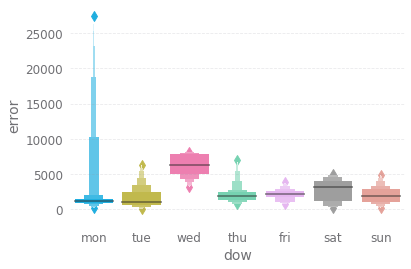

In [20]:
# showing the errors per day
sns.boxenplot(x='dow',
              y='error',
              data=diff_in_prediction)
plt.xticks(ticks=range(0,7),
           labels=days);

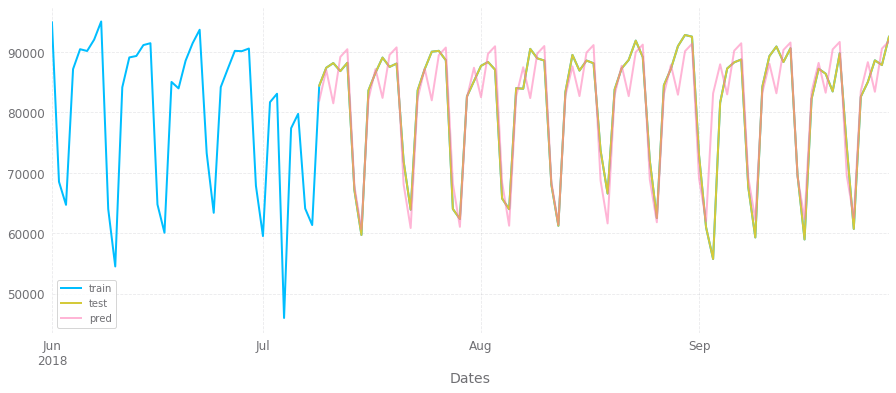

In [21]:
daily['2018-06-01':].plot(label='train')
test.plot(label='test')
pred.plot(alpha=.5,
          figsize=(15,6),
          label='pred')

plt.ylabel('')
plt.xlabel('Dates')
plt.legend();

_____ 

# Holt-Winters'

In [22]:
from statsmodels.tsa.holtwinters import ExponentialSmoothing

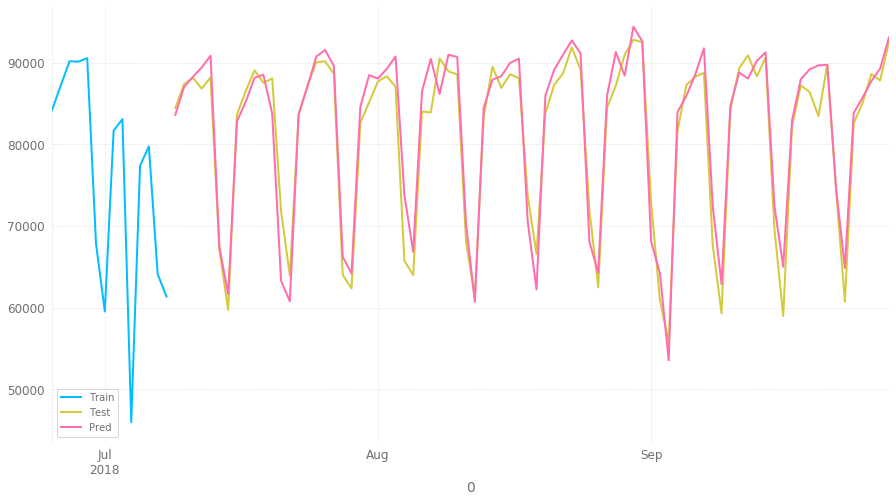

In [23]:
model = ExponentialSmoothing(train,
                             seasonal='mul',
                             seasonal_periods=364)

hw_results = model.fit(use_boxcox=True,
                    smoothing_level=.1)

hw_pred = hw_results.predict(start=test.index[0],
                             end=test.index[-1])


holt_mse = mean_squared_error(test, hw_pred)

train[-7*2:].plot(label = 'Train')
test.plot(label = 'Test')
hw_pred.plot(label = 'Pred',
          figsize=(15,8))
plt.legend(loc='best')
hw_pred = hw_pred.fillna(0);

____

# Prophet

In [24]:
from fbprophet import Prophet
from fbprophet.plot import plot_plotly
import plotly.offline as py
py.init_notebook_mode()

In [25]:
# transform the dataframe to include the specifics of Prophet's 'ds' and 'y' column naming
prophet_df_train = pd.DataFrame(train).reset_index()
prophet_df_test = pd.DataFrame(test).reset_index()

prophet_df_train = prophet_df_train.rename(columns={0:'ds','traffic_filled':'y'})
prophet_df_test = prophet_df_test.rename(columns={0:'ds','traffic_filled':'y'})

# create model
model = Prophet(changepoint_range=0.8,
               seasonality_mode='additive')

# fit
model.fit(prophet_df_train);

# create daterange X amount of days into the future
future_dates = model.make_future_dataframe(periods=len(prophet_df_test),freq='D')

# create actual predictions
p_res = model.predict(future_dates)

# create metrics
p_mean = abs(test.values - p_res['yhat'][-82:]).mean()
p_max = abs(test.values - p_res['yhat'][-82:]).max()
p_min = abs(test.values - p_res['yhat'][-82:]).min()
p_mse = mean_squared_error(test, p_res['yhat'][-82:])

INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


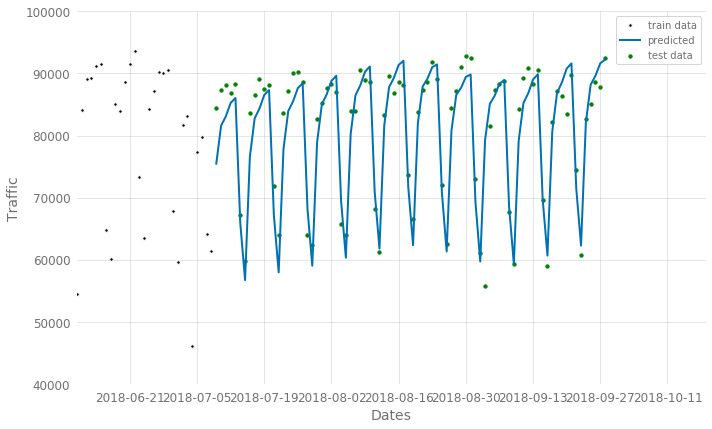

In [26]:
# plot the predictions
model.plot(p_res[-82:][['ds','yhat']],
           plot_cap=True,
           xlabel='Dates',
           ylabel='Traffic',
          uncertainty=False)

plt.scatter(x=test.index,
            y=test,
            color='green',
            s=11)

plt.legend(['train data', 'predicted', 'test data'])

plt.xlim(736855.05,736985.95)
plt.ylim(40000,100000);

In [27]:
pd.to_pickle(p_res['yhat'], 'prophet pickle')

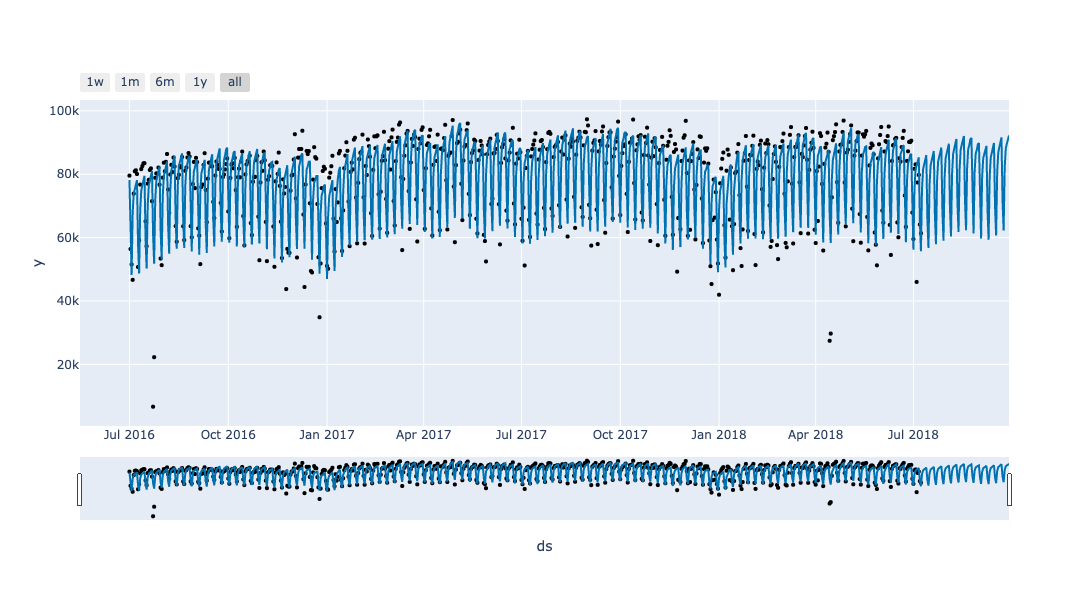

In [28]:
# easily create an interactive chart for the plot
fig = plot_plotly(model, p_res, uncertainty=False)
py.iplot(fig)

____

# Results

In [29]:
print(f'SARIMA MSE: {mse}')
print(f'Holt Winters MSE: {holt_mse}')
print(f'Prophet MSE: {p_mse}')

SARIMA MSE: 20245796.813522413
Holt Winters MSE: 7852221.303622513
Prophet MSE: 16533075.905893274


In [30]:
print(f'SARIMA mean error: {abs(test - pred).mean()}')
print(f'SARIMA max error: {abs(test - pred).max()}')
print(f'SARIMA min error: {abs(test - pred).min()}')

SARIMA mean error: 2939.15989538399
SARIMA max error: 27393.069992046687
SARIMA min error: 37.45749240335135


In [31]:
print(f'Holt-Winters\' mean error: {abs(test - hw_pred).mean()}')
print(f'Holt-Winters\' max error: {abs(test - hw_pred).max()}')
print(f'Holt-Winters\' min error: {abs(test - hw_pred).min()}')

Holt-Winters' mean error: 2169.4422952730397
Holt-Winters' max error: 8561.108532580853
Holt-Winters' min error: 9.25686572882114


In [32]:
print(f'Prophet mean error: {p_mean}')
print(f'Prophet max error: {p_max}')
print(f'Prophet min error: {p_min}')

Prophet mean error: 2796.0122682218407
Prophet max error: 23472.957749415044
Prophet min error: 30.432643297492177
